## Imports


In [4]:
import os
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [ ]:
import requests
import tarfile
import os

# URL of the dataset
url = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz'

# Create the images directory if it does not exist
os.makedirs('images2', exist_ok=True)

# Download the dataset
response = requests.get(url, stream=True)

# Check if the download was successful
if response.status_code == 200:
    # Open a local file for writing the downloaded content
    with open('images2/images.tar.gz', 'wb') as f:
        f.write(response.raw.read())
    
    # Extract the tar file
    with tarfile.open('images2/images.tar.gz', 'r:gz') as tar:
        tar.extractall(path='images2')
    
    print("Download and extraction complete!")
else:
    print("Failed to download the file. Status code:", response.status_code)


## Definition of global constants

In [5]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'images')

## Creation of Dataset and Dataset helper functions

We store the labels for each image by creating a dict {'image-name' : [label1, label2, label3]} using list.txt

In [6]:
def create_image_labels(file : str):
    """
    This function takes a file name as argument and returns a dict containing the image-name, label pairs and a list of the image names in the order they 
    appear in the list.
    Args:
        file : str, denotes the filename for the file containing the images and labels ()
    Returns:
        IMG_LABELS : dict, format {'image-name' : [label1, label2, label3]}
        IMG_NAMES : list, ['image1-name', image2, ...]
    """
    import re
    IMG_LABELS = {}
    IMG_NAMES = []
    pattern = r'^[A-Za-z0-9_]+\s+\d+\s+\d+\s+\d+$'
    # Function to check if a line is valid
    def is_valid_line(line):
        return re.match(pattern, line) is not None

    filename = 'annotations/' + file
    # create dict from list.txt
    with open(filename, 'r') as file:

        # Read each line in the file
        for line in file:
            # use regex
            if is_valid_line(line):
                # Split the line into tokens
                tokens = line.split()
                
                # Extract the image name and attributes
                image_name = tokens[0]
                attributes = [int(token) for token in tokens[1:]]
                IMG_NAMES.append(image_name)
                # Add entry to the dictionary
                IMG_LABELS[image_name] = attributes
    return IMG_LABELS, IMG_NAMES

Lets define the dataset. We let the "target_transform" function specify if we want the binary label or breed etc

In [7]:
from torchvision.io import ImageReadMode

class CatAndDogsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        self.img_labels = {'Abyssninan101' : [1, 1, 1], ...}
        self.img_names = ['Abyssnian101', ...]
        """
        self.img_labels, self.img_names = create_image_labels(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+'.jpg')
        image = read_image(img_path, mode=ImageReadMode.RGB) # this is intended to solve problem with extra channel on one image
        label = self.img_labels[img_name]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Defining transforms for images and labels. These are used for preprocessing each image used in the model

In [8]:
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights

# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



binary_transform = lambda x: x[1]-1 # for binary classification problem we only care about the cat/dog label


## Finetuning a pretrained model for binary-classification problem

First we download the model with pretrained weights and change the fully connected layer

In [9]:
from torchvision import models
from torch import nn


model = models.resnet34(weights='DEFAULT')

num_classes = 2 # 2 for cats and dogs, 1 for background

# Freeze all layers except last one
for param in model.parameters():
    param.requires_grad = False

# Change the output layer
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/lucasdow/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 15.6MB/s]


We now define the training/test functions as implemented in 
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Args:
        **kwargs : {
            'print_every' : int,
        }
    """
    print_every = int(kwargs.get('print_every', 10))

    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model.to(device)  # Move the model to the device
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move the data to the device

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if DEBUG and batch % print_every == 0:
            loss, current_batch = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  Current image:[{current_batch:>5d}/{size:>5d}]")

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Args:
        **kwargs : {
            'print_every' : int,
        }
    """
    print_every = int(kwargs.get('print_every', 10))

    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model.to(device)  # Move the model to the device
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move the data to the device

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if DEBUG and batch % print_every == 0:
            loss, current_batch = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  Current image:[{current_batch:>5d}/{size:>5d}]")

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Args:
        **kwargs : {
            'print_every' : int,
        }
    """
    print_every = int(kwargs.get('print_every', 10))

    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model.to(device)  # Move the model to the device
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move the data to the device

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if DEBUG and batch % print_every == 0:
            loss, current_batch = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  Current image:[{current_batch:>5d}/{size:>5d}]")

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Args:
        **kwargs : {
            'print_every' : int,
        }
    """
    print_every = int(kwargs.get('print_every', 10))

    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model.to(device)  # Move the model to the device
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move the data to the device

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if DEBUG and batch % print_every == 0:
            loss, current_batch = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  Current image:[{current_batch:>5d}/{size:>5d}]")

In [11]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Next we create the datasets for training, validation and testing

In [12]:
training_data = CatAndDogsDataset('trainval.txt', IMAGE_PATH, transform=train_transform, target_transform=breed_transform)
validation_data = CatAndDogsDataset('trainval.txt', IMAGE_PATH, transform=val_transform, target_transform=breed_transform)
test_data = CatAndDogsDataset('test.txt', IMAGE_PATH, transform=val_transform, target_transform=breed_transform)

"""
What follows is a hacky way to shuffle the train/val-data into a training and validation set
"""
# shuffle and split into validation and training
import random

indices = list(range(len(training_data)))
random.seed(310)  # fix the seed
random.shuffle(indices)

train_size = int(0.8 * len(training_data))
train_dataset_split = torch.utils.data.Subset(training_data, indices[:train_size])
val_dataset_split = torch.utils.data.Subset(validation_data, indices[train_size:])

Now we set the hyperparameters for training

In [17]:
learning_rate = 1e-3
batch_size = 32
epochs = 2

We create the loaders for the datasets to speedup processing

In [15]:
train_dataloader = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_split, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

We train the network using said parameters, running the test-loop on the validation set for each epoch to see if the model improves

In [18]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
print(model.summary())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Training done!")

Epoch 1
-------------------------------
loss: 0.130827  Current image:[   32/ 2944]
loss: 0.242727  Current image:[  352/ 2944]
loss: 0.089935  Current image:[  672/ 2944]
loss: 0.134018  Current image:[  992/ 2944]
loss: 0.222667  Current image:[ 1312/ 2944]


Finally we check the final result on the test-dataset

In [163]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.034052 



Lets see some examples

In [166]:
# show 10 images and the label that the model predicts
def visualize_model(model, num_images=10):
    label_to_pred = {'0': 'Cat', '1': 'Dog'}
    model.eval()
    
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))

    with torch.no_grad():
        for i in range(num_images):
            # randomize image to plot
            idx = random.randint(0, len(test_data))
            img, label = test_data[idx]
            pred = model(img.unsqueeze(0))
            pred_label = pred.argmax(1).item()
            axs[i].imshow(img.permute(1, 2, 0))
            axs[i].set_title(f"Predicted: {label_to_pred[str(pred_label)]} \n True: {label_to_pred[str(label)]}")
            axs[i].axis('off')
    plt.show()
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

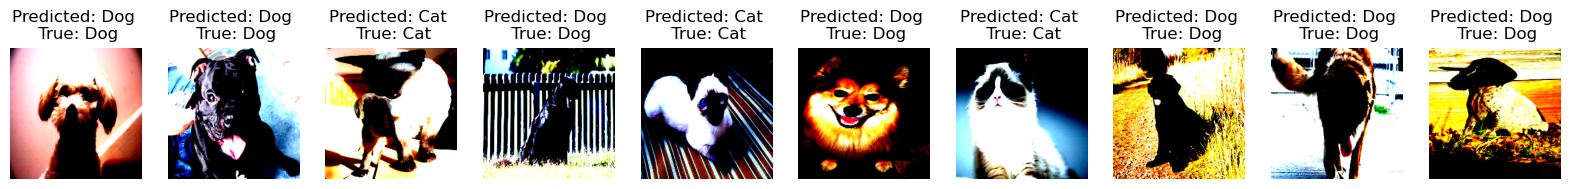

In [169]:
visualize_model(model)